

# Reto Pokemon Legendarios

<img src="https://archives.bulbagarden.net/media/upload/thumb/a/aa/2018_Legendary_Pokemon_Distributions_artwork.png/800px-2018_Legendary_Pokemon_Distributions_artwork.png" alt="Logo Python" width="">


Para practicar lo que hemos aprendido hasta ahora sobre EDA y modelos de clasificación, vamos a intentar encontrar un modelo de aprendizaje supervisado que nos permita clasificar los Pokémon en legendarios y no legendarios.

Para ello, vamos a usar un conjunto de datos que contiene información sobre los 801 Pokémon de las siete primeras generaciones. La información contenida en este conjunto de datos incluye estadísticas básicas, rendimiento frente a otros tipos, altura, peso, clase a la que pertenecen, puntos de experiencia, habilidades, etc.

La información para crear este conjunto de datos, el cual puede descargarse en Kaggle de [The Complete Pokemon Dataset](https://www.kaggle.com/rounakbanik/pokemon?select=pokemon.csv), se extrajo de http://serebii.net/ mediante _web scraping_.

Este conjunto de datos contiene 41 columnas, siendo su interpretación la siguiente:
* `name` - El nombre en inglés del Pokémon.
* `japanese_name` - El nombre japonés original del Pokémon
* `pokedex_number` - El número de entrada del Pokémon en el Pokédex Nacional
* `percent_male` - El porcentaje de la especie que son machos. En blanco si el Pokémon no tiene género.
* `type1` - El tipo primario del Pokémon
* `type2` - El tipo secundario del Pokémon
* `classification` - La clasificación de los Pokémon como se describe en el Pokédex Sol y Luna
* `height_m` - Altura del Pokémon en metros
* `weight_kg` - Peso del Pokémon en kilogramos
* `capture_rate` - Tasa de captura del Pokémon
* `baseeggsteps` - El número de pasos necesarios para eclosionar un huevo del Pokémon
* `abilities` - Una lista ordenada de habilidades que el Pokémon puede tener
* `experience_growth` - La experiencia de crecimiento de los Pokémon
* `base_happiness` - Felicidad de base del Pokémon
* `against_?` - Dieciocho características que denotan la cantidad de daño recibido contra un ataque de un tipo particular
* `hp` - El _hit point_ de base del Pokémon. Es una estadística que determina cuánto daño puede recibir un Pokémon antes de desmayarse
* `attack` - El ataque base del Pokémon
* `defense` - La defensa base del Pokémon
* `sp_attack` - El ataque especial base del Pokémon
* `sp_defense` - La defensa especial base del Pokémon
* `speed` - La velocidad base del Pokémon
* `base_total` - Suma de `hp`, `attack`, `defense`, `sp_attack`, `sp_defense` y `speed`
* `generation` - La generación en la que se introdujo por primera vez el Pokémon
* `is_legendary` - Indica si el Pokémon es o no legendario y es la etiqueta que vamos a tratar de predecir

Pero, ¿qué es lo que hace a un Pokémon ser legendario? Consultando [The Bulbapedia Wiki](https://bulbapedia.bulbagarden.net/wiki/Legendary_Pokémon), los Pokémon legendarios

> _...son un grupo de Pokémon increíblemente raros y, a menudo, muy poderosos, que generalmente ocupan un lugar destacado en las leyendas y los mitos del mundo Pokémon... No hay criterios explícitos que definan qué hace que un Pokémon sea un Pokémon legendario. En cambio, la única forma de identificar a un Pokémon como perteneciente a este grupo es a través de declaraciones de medios oficiales, como los juegos o el anime._

Aunque por lo que parece no existen criterios explícitos sobre lo que define a un Pokémon como legendario, vamos a comprobar si usando las estadísticas de cada Pokémon podemos encontrar algún modelo de clasificación que nos permita predecir si un Pokémon es o no legendario.

## Importar librerías

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import plot_tree, export_text
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

## Importar y explorar los datos

**Carga los datos en un DataFrame de Pandas y llámalo `data`.**

In [ ]:
data = pd.read_csv("pokemon.csv")


**Muestra las 5 primeras filas.**

In [ ]:
data.head(5)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


**Muestra las 5 últimas filas.**

In [ ]:
data.tail(5)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1
800,['Soul-Heart'],0.25,0.5,0.0,1.0,0.5,1.0,2.0,0.5,1.0,...,NaN,801,130,115,65,steel,fairy,80.5,7,1


**Imprime la información del dataset.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

**Muestras el resumen estadístico de las variables numéricas del conjunto de datos.**

In [ ]:
data.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.080326,26.576015,20.261623,231.373075,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,0.100000,1.000000,0.000000,1.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,0.600000,50.000000,50.000000,201.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.500000,80.000000,50.000000,601.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,14.500000,255.000000,100.000000,801.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


**Muestra el resumen estadístico de las variables de tipo `Object` del conjunto de datos. ¿Notas algo raro?**

In [ ]:
data.describe(include = object)

,abilities,capture_rate,classfication,japanese_name,name,type1,type2
count,801,801,801,801,801,801,417
unique,482,34,588,801,801,18,18
top,['Levitate'],45,Dragon Pokémon,Magearnaマギアナ,Magearna,water,flying
freq,29,250,8,1,1,114,95


**Comprueba qué variables tienen valores ausentes y cuántos. Muestra solo las variables que tienen valores ausentes.**

In [ ]:
# Calculamos el número de valores ausentes

null_columns=data.columns[data.isnull().any()]

# Filtramos por las variables que tienen valores ausentes


data[null_columns].isnull().sum()

,0
height_m,20
percentage_male,98
type2,384
weight_kg,20




**Usa un mapa de calor para mostrar las variables que tienen valores ausentes. Investiga la librería [`missingno`](https://github.com/ResidentMario/missingno), aunque no es necesario que la uses para responder a esta cuestión.**

In [ ]:
pip install missingno

<Axes: >

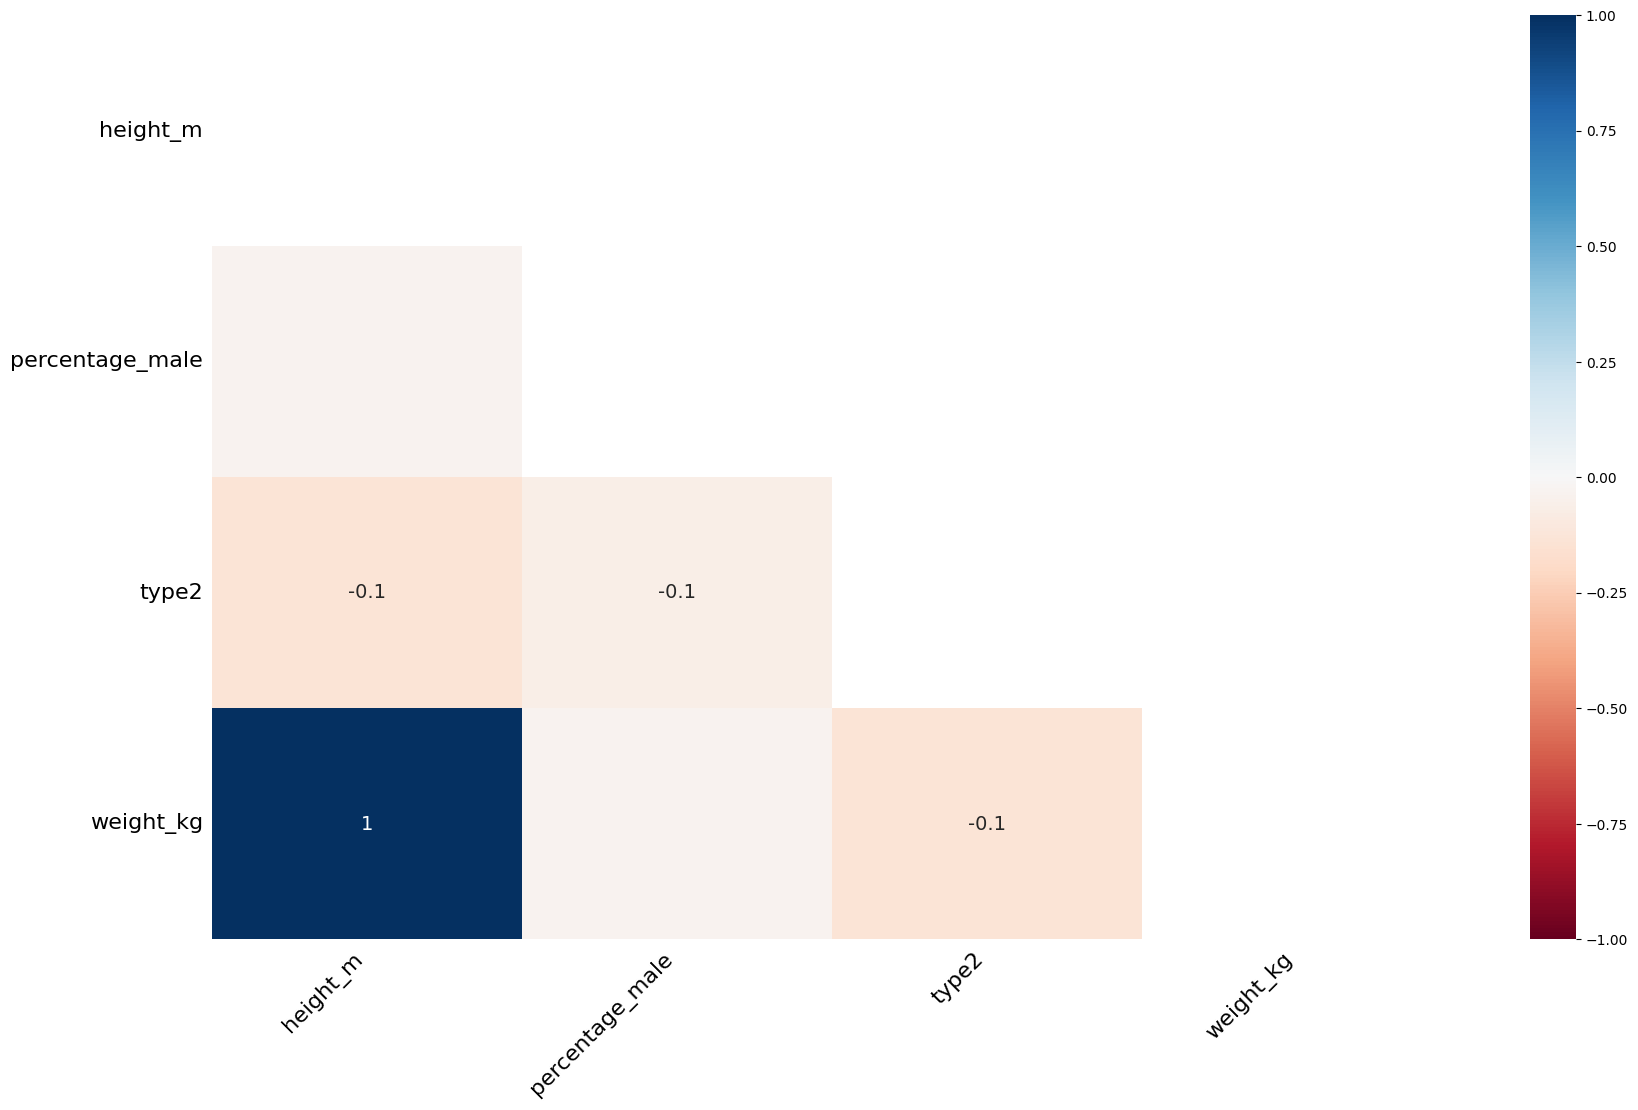

In [ ]:
import missingno as msno

msno.heatmap(data)

<Axes: >

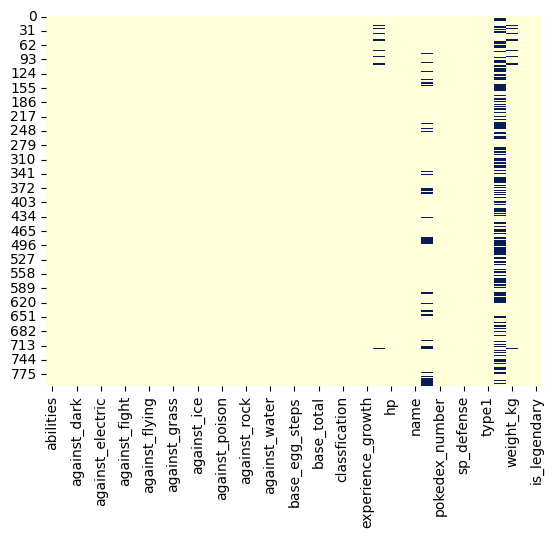

In [ ]:
sns.heatmap(data.isnull(), cmap="YlGnBu", cbar=False)

**Haz un recuento de la variable de salida `is_legendary` que es la que queremos predecir. ¿Está balanceado el conjunto de datos?**

In [ ]:
data['is_legendary'].value_counts()

,count
is_legendary,
0,731
1,70


**Crea un piechart que muestre la proporción de Pokémon legendarios frente a los no legendarios.**

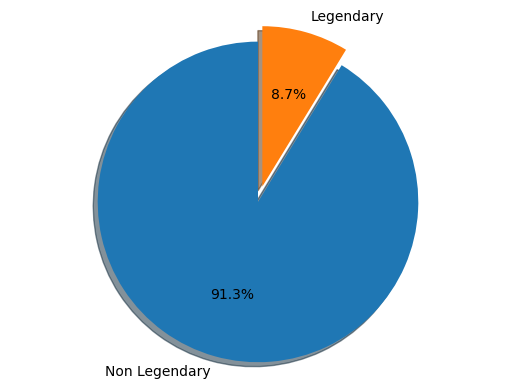

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Non Legendary','Legendary'
sizes = [data['is_legendary'].value_counts()[0], data['is_legendary'].value_counts()[1]]

explode = (0, 0.1)
# only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
# Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

**Muestra una visualización con cuántos Pokémons hay en cada generación en función de la variable de salida e imprime un conteo de los mismos. ¿Ves algún patrón en los datos?**

    generation  is_legendary  Generation Count
0            1             0               146
1            1             1                 5
2            2             0                94
3            2             1                 6
4            3             0               125
5            3             1                10
6            4             0                94
7            4             1                13
8            5             0               143
9            5             1                13
10           6             0                66
11           6             1                 6
12           7             0                63
13           7             1                17


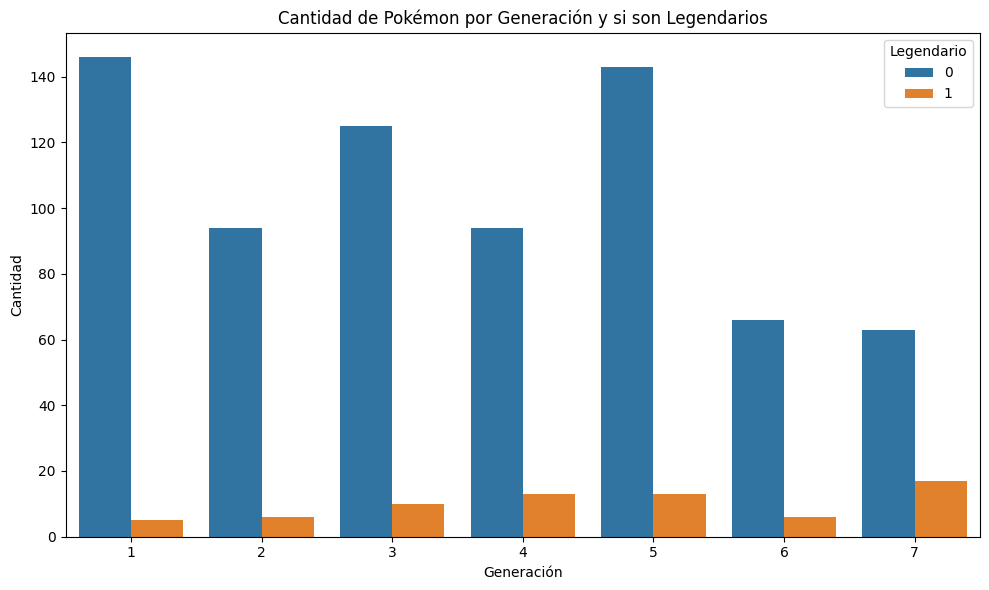

In [ ]:
generation_count = data.groupby(['generation', 'is_legendary']).size().reset_index(name='Generation Count')

# Mostrar tabla de generation_count
print(generation_count)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=generation_count, x='generation', y='Generation Count', hue='is_legendary')
plt.title('Cantidad de Pokémon por Generación y si son Legendarios')
plt.xlabel('Generación')
plt.ylabel('Cantidad')
plt.legend(title='Legendario')
plt.tight_layout()
plt.show()

**Como hemos comentado, la variable `capture_rate` parece que debería ser numérica pero vemos que es de tipo `Object`, necesitamos saber qué ocurre. Muestra los posibles valores que puede tomar esta variable.**

In [ ]:
capture_rate_dtype = data['capture_rate'].dtype
unique_capture_rates = data['capture_rate'].unique()

capture_rate_dtype, unique_capture_rates[:20]

(dtype('O'),
 array(['45', '255', '120', '127', '90', '190', '75', '235', '150', '25',
        '170', '50', '200', '100', '180', '60', '225', '30', '35', '3'],
       dtype=object))

**Parece que hay algún Pokémon que tiene 2 valores para esta variable. Localiza qué Pokémon son, es decir, cómo se llaman.**

In [ ]:
non_numeric_capture_rate = data[~data['capture_rate'].str.fullmatch(r'\d+')]

non_numeric_capture_rate[['name', 'capture_rate']]

,name,capture_rate
773,Minior,30 (Meteorite)255 (Core)


**Ahora que hemos localizado el Pokémon que está dando problemas, sustituye su `capture_rate` por el valor 30 y transforma esta columna en una de tipo numérico.**

In [ ]:
# Cambiamos el capture_rate por '30'
data.loc[data['name'] == 'Minior', 'capture_rate'] = '30'

In [ ]:
# Transformamos la columna en numérica
data['capture_rate'] = pd.to_numeric(data['capture_rate'])

# Comprobamos el tipo de la columna
data['capture_rate'].dtype

dtype('int64')

**Sabemos que los Pokémon legendarios son "poco comunes" y "poderosos", los atributos que reflejan estas cualidades pueden darnos una mejor idea de cómo podemos predecir si un Pokémon es legendario. Debido a que los Pokémon legendarios son raros, sabemos que capturarlos puede ser más difícil que atrapar Pokémons no legendarios.**

**Muestra con un boxplot cómo se distribuye la variable `capture_rate` en función de si son o no legendarios. ¿Cómo interpretas el resultado?**

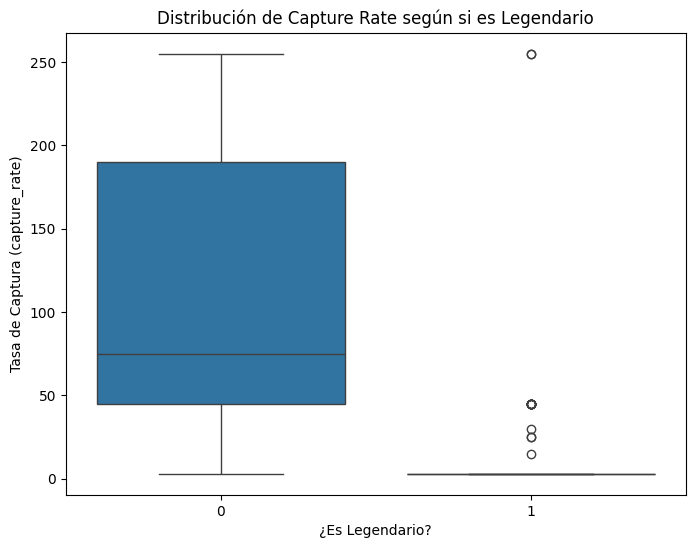

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='is_legendary', y='capture_rate')
plt.title('Distribución de Capture Rate según si es Legendario')
plt.xlabel('¿Es Legendario?')
plt.ylabel('Tasa de Captura (capture_rate)')
plt.show()

**Haz lo mismo con `base_total` que muestra de forma resumida las estadísticas de fuerza, ataque, defensa y velocidad de cada Pokémon.**

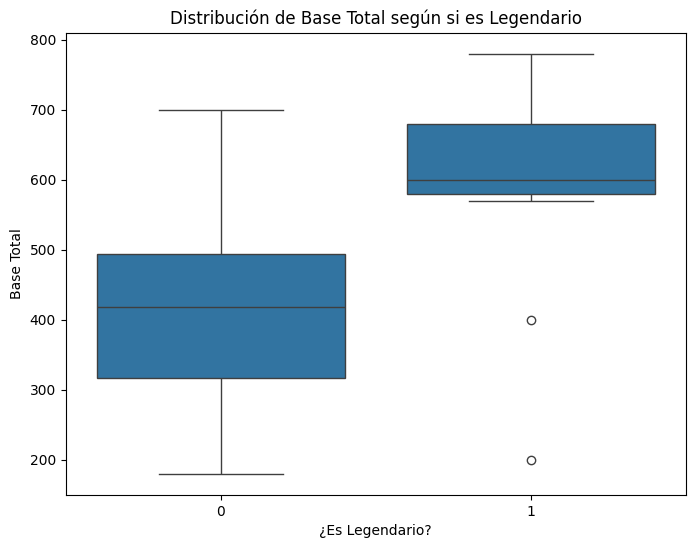

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='is_legendary', y='base_total')
plt.title('Distribución de Base Total según si es Legendario')
plt.xlabel('¿Es Legendario?')
plt.ylabel('Base Total')
plt.show()

**Crea un DataFrame con los recuentos de las clases de cada tipo.**

In [ ]:
# Crear tabla de frecuencias cruzadas entre tipo y si es legendario o no
counts = pd.crosstab(data['type1'], data['is_legendary'])

# Convertir a DataFrame y ordenar por cantidad total
counts_df = counts.reset_index().sort_values(by=False, ascending=False)  # Ordena por no legendarios

# Mostrar resultado
print(counts_df)

is_legendary     type1    0   1
17               water  108   6
12              normal  102   3
9                grass   74   4
0                  bug   69   3
6                 fire   47   5
15                rock   41   4
14             psychic   36  17
3             electric   34   5
13              poison   32   0
10              ground   30   2
5             fighting   28   0
1                 dark   26   3
8                ghost   26   1
11                 ice   21   2
2               dragon   20   7
16               steel   18   6
4                fairy   17   1
7               flying    2   1


**Usando el DataFrame anterior, muestra en un diagrama de barras apilado cuántos Pokémons hay de cada tipo. ¿Qué conclusiones sacas?**

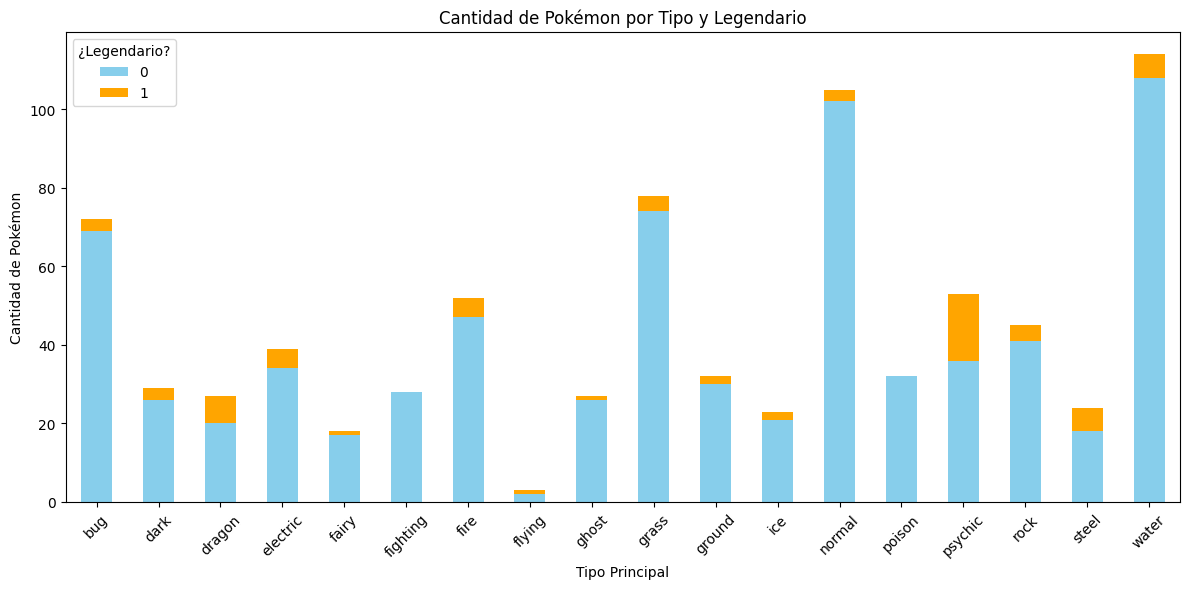

In [ ]:
type_legendary_counts = pd.crosstab(data['type1'], data['is_legendary'])

# Crear gráfico de barras apilado
type_legendary_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=["skyblue", "orange"])
plt.title('Cantidad de Pokémon por Tipo y Legendario')
plt.xlabel('Tipo Principal')
plt.ylabel('Cantidad de Pokémon')
plt.legend(title='¿Legendario?')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Reemplaza los valores nulos de la variable `type2` con el valor `N/A` y comprueba que ha funcionado.**

In [ ]:
# Hacemos el reemplazo
data['type2'].fillna('N/A', inplace=True)

# Verificar si hay valores nulos en 'type2'
null_check = data['type2'].isnull().sum()

# Mostrar algunas filas de las columnas relevantes
sample_data = data[['type1', 'type2', 'is_legendary']].head()

# Comprobamos que ha funcionado
null_check, sample_data

<ipython-input-246-8287c06b2a36>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['type2'].fillna('N/A', inplace=True)


(np.int64(0),
    type1   type2  is_legendary
 0  grass  poison             0
 1  grass  poison             0
 2  grass  poison             0
 3   fire     N/A             0
 4   fire     N/A             0)

**Comprueba si algún Pokémon tiene el mismo valor en `type1` y `type2`. Esto no tiene mucho sentido, por lo que si es así sustituye `type2` por `N/A` para ese Pokémon.**

In [ ]:
# Comprobamos si hay alguno
same_type = data[data['type1'] == data['type2']]

In [ ]:
# Los mostramos
same_type_display = same_type[['type1', 'type2', 'is_legendary']]
same_type_display

,type1,type2,is_legendary
25,electric,electric,0
49,ground,ground,0
50,ground,ground,0
87,poison,poison,0
88,poison,poison,0
491,grass,grass,1
554,fire,fire,0


In [ ]:
# Cambiamos el type2 por 'N/A'
data.loc[data['type1'] == data['type2'], 'type2'] = 'N/A'

In [ ]:
# Volvemos a comprobar si hay alguno
same_type = data[data['type1'] == data['type2']]
same_type_display = same_type[['type1', 'type2', 'is_legendary']]
same_type_display

,type1,type2,is_legendary


**Crea una nueva variable llamada `type` que combine ambos tipos. Si el Pokémon solo tiene `type1` dejamos eso, si tiene los dos creamos una cadena de tipo `type1_type2`.**

In [ ]:
data['type'] = data.apply(lambda row: row['type1'] if row['type2'] == 'N/A' else f"{row['type1']}_{row['type2']}", axis=1)

# Recuento de los valores obtenidos
type_counts = data['type'].value_counts()

type_counts.head(15)

,count
type,
water,61
normal,61
grass,38
psychic,35
fire,28
electric,27
normal_flying,26
fighting,22
bug,18


**¿Cuáles son los 5 tipos más comunes para los Pokémon legendarios?**

In [ ]:
#Filtramos solo los Pokémon legendarios
legendary_data = data[data['is_legendary'] == 1]

# Recuento de los tipos entre los legendarios
legendary_type_counts = legendary_data['type'].value_counts().head(5)

legendary_type_counts

,count
type,
psychic,10
water,3
fire_flying,2
electric_flying,2
normal,2


**Usando un mapa de calor, muestra todas las combinaciones de tipos de los Pokémon. Ten en cuenta que solo debes incluir los Pokémon que tienen tanto un tipo primario como uno secundario.**

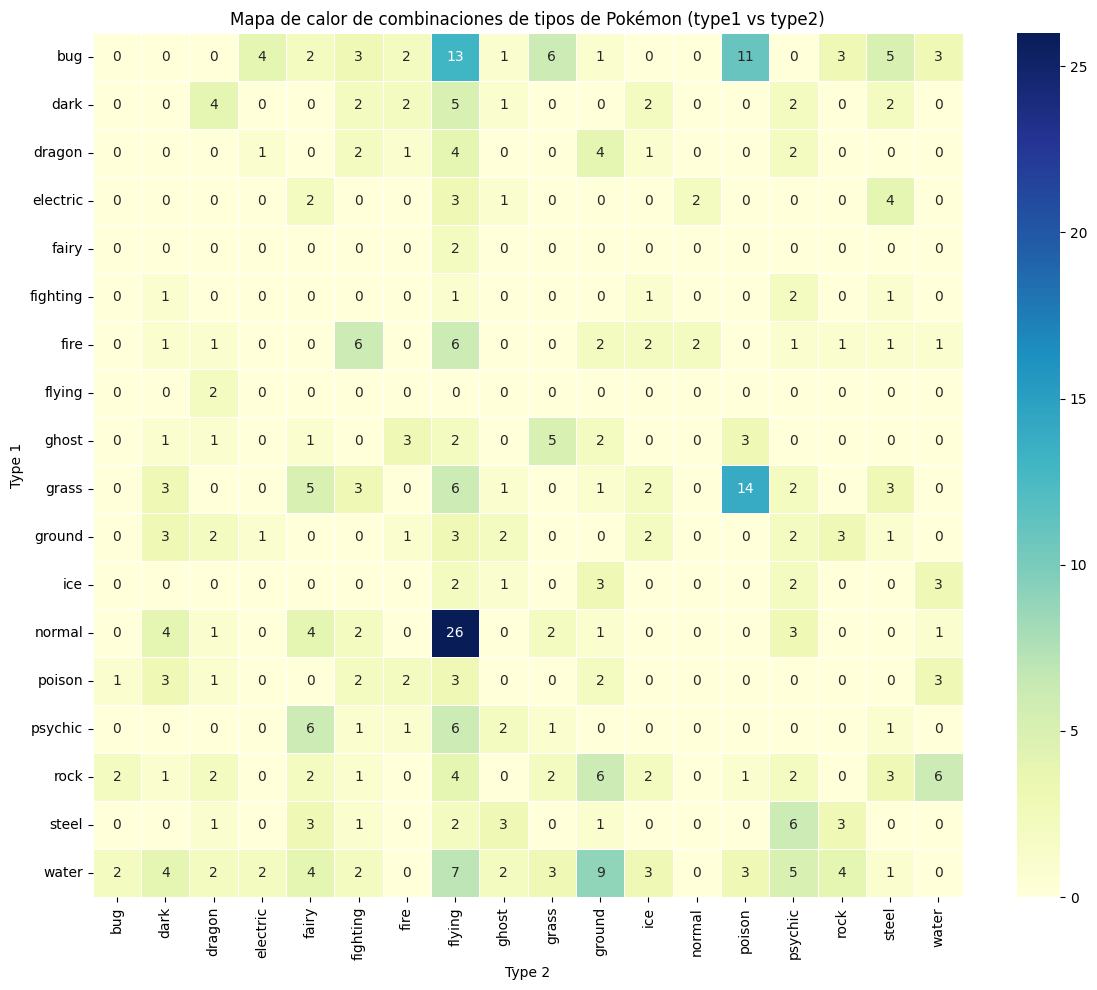

In [ ]:
#Filtramos Pokémon con ambos tipos (type2 distinto de 'N/A')
dual_type_data = data[data['type2'] != 'N/A']

# Creamos una tabla de frecuencia de combinaciones type1 vs type2
type_comb_matrix = pd.crosstab(dual_type_data['type1'], dual_type_data['type2'])

# Dibujamos el mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(type_comb_matrix, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
plt.title('Mapa de calor de combinaciones de tipos de Pokémon (type1 vs type2)')
plt.ylabel('Type 1')
plt.xlabel('Type 2')
plt.tight_layout()
plt.show()

**Comprueba si existe alguna correlación entre los tipos de Pokémon y la variable que queremos predecir. Necesitarás convertir las variables categóricas `type1` y `type2` a numéricas usando `pd.get_dummies()`. Interpreta los resultados.**

In [ ]:
# [ ] ## type1
# Convertimos 'type1' en variables dummies
type1_dummies = pd.get_dummies(data['type1'], prefix='type1')

# Calculamos la correlación con 'is_legendary'
type1_corr = type1_dummies.join(data['is_legendary']).corr()['is_legendary'].drop('is_legendary').sort_values(ascending=False)

type1_corr

,is_legendary
type1_psychic,0.219961
type1_dragon,0.113667
type1_steel,0.101196
type1_flying,0.053397
type1_electric,0.032696
type1_dark,0.011020
type1_fire,0.008176
type1_rock,0.001294
type1_ice,-0.000264
type1_fairy,-0.017092


In [ ]:
# [ ] ## type2
# Convertimos 'type2' en variables dummies
type2_dummies = pd.get_dummies(data['type2'], prefix='type2')

# Calculamos la correlación con 'is_legendary'
type2_corr = type2_dummies.join(data['is_legendary']).corr()['is_legendary'].drop('is_legendary').sort_values(ascending=False)

type2_corr

,is_legendary
type2_fighting,0.096994
type2_fairy,0.082017
type2_dragon,0.077120
type2_steel,0.056191
type2_psychic,0.034686
type2_fire,0.034619
type2_ghost,0.026196
type2_flying,0.023215
type2_electric,0.013376
type2_ice,-0.010138


**Imprime un listado con todas las habilidades posibles que puede tener un Pokémon y cuéntalas. Investiga la función `eval()` para devolver el tipo `list()` a los valores de las celdas de esta variable que ahora mismo están en formato cadena de texto.**

In [ ]:
# Comprobamos que el contenido de las celdas es una cadena
data['abilities'] = data['abilities'].apply(eval)

In [ ]:
# Transformamos las cadenas en listas
all_abilities = [ability for sublist in data['abilities'] for ability in sublist]


In [ ]:
# Comprobamos que el contenido de las celdas ahora es una lista

# Obtener habilidades únicas
unique_abilities = set(all_abilities)

# Imprimir todas las habilidades y cuántas hay
print(f"Número total de habilidades únicas: {len(unique_abilities)}\n")
print("Listado de habilidades:")
for ability in sorted(unique_abilities):
    print(ability)

Número total de habilidades únicas: 227

Listado de habilidades:
Adaptability
Aftermath
Air Lock
Analytic
Anger Point
Anticipation
Arena Trap
Aroma Veil
Aura Break
Bad Dreams
Battery
Battle Armor
Battle Bond
Beast Boost
Berserk
Big Pecks
Blaze
Bulletproof
Cheek Pouch
Chlorophyll
Clear Body
Cloud Nine
Color Change
Comatose
Competitive
Compoundeyes
Contrary
Corrosion
Cursed Body
Cute Charm
Damp
Dancer
Dark Aura
Dazzling
Defeatist
Defiant
Disguise
Download
Drizzle
Drought
Dry Skin
Early Bird
Effect Spore
Electric Surge
Emergency Exit
Fairy Aura
Filter
Flame Body
Flare Boost
Flash Fire
Flower Gift
Flower Veil
Fluffy
Forecast
Forewarn
Friend Guard
Frisk
Full Metal Body
Fur Coat
Gale Wings
Galvanize
Gluttony
Gooey
Grass Pelt
Grassy Surge
Guts
Harvest
Healer
Heatproof
Heavy Metal
Honey Gather
Huge Power
Hustle
Hydration
Hyper Cutter
Ice Body
Illuminate
Illusion
Immunity
Imposter
Infiltrator
Innards Out
Inner Focus
Insomnia
Intimidate
Iron Barbs
Iron Fist
Justified
Keen Eye
Klutz
Leaf Guard
Le

**Crea otra característica que sea más informativa a partir de `abilities` con el número de habilidades de cada Pokémon y nómbrala `n_abilities`.**

In [ ]:
# Creamos la nueva variable con el número de habilidades
data['abilities'] = data['abilities'].apply(lambda x: x if isinstance(x, list) else eval(x))

In [ ]:
# Hacemos un recuento para comprobar que ha funcionado
data['n_abilities'] = data['abilities'].apply(len)

# Mostrar un resumen para comprobar
print(data[['abilities', 'n_abilities']].head(10))

                 abilities  n_abilities
0  [Overgrow, Chlorophyll]            2
1  [Overgrow, Chlorophyll]            2
2  [Overgrow, Chlorophyll]            2
3     [Blaze, Solar Power]            2
4     [Blaze, Solar Power]            2
5     [Blaze, Solar Power]            2
6     [Torrent, Rain Dish]            2
7     [Torrent, Rain Dish]            2
8     [Torrent, Rain Dish]            2
9  [Shield Dust, Run Away]            2


**Muestra un gráfico que relacione el número de habilidades que un Pokémon puede tener con la variable de salida y explica si encuentras algún patrón.**

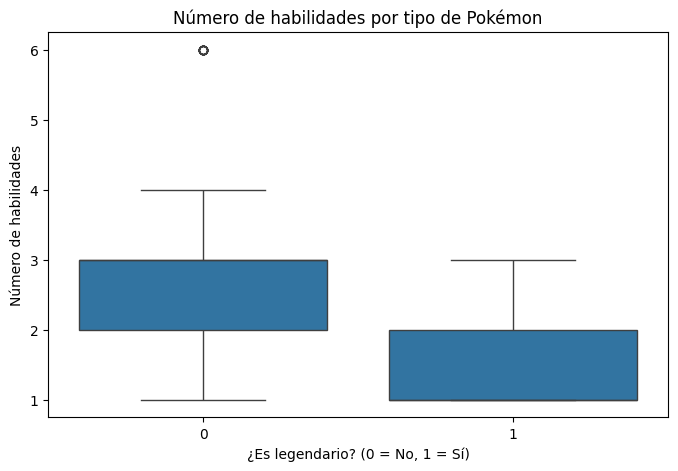

In [ ]:
# Asegúrate de que 'n_abilities' existe
if 'n_abilities' not in data.columns:
    data['n_abilities'] = data['abilities'].apply(len)

# Convertimos la variable is_legendary a string para mejor visualización
data['is_legendary'] = data['is_legendary'].astype(str)

# Crear boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_legendary', y='n_abilities', data=data)
plt.title('Número de habilidades por tipo de Pokémon')
plt.xlabel('¿Es legendario? (0 = No, 1 = Sí)')
plt.ylabel('Número de habilidades')
plt.show()

**Vamos a analizar usando una serie de boxplots cómo se distribuyen las características `['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'hp', 'sp_attack', 'sp_defense', 'speed']` en función de si los Pokémon son o no legendarios.**

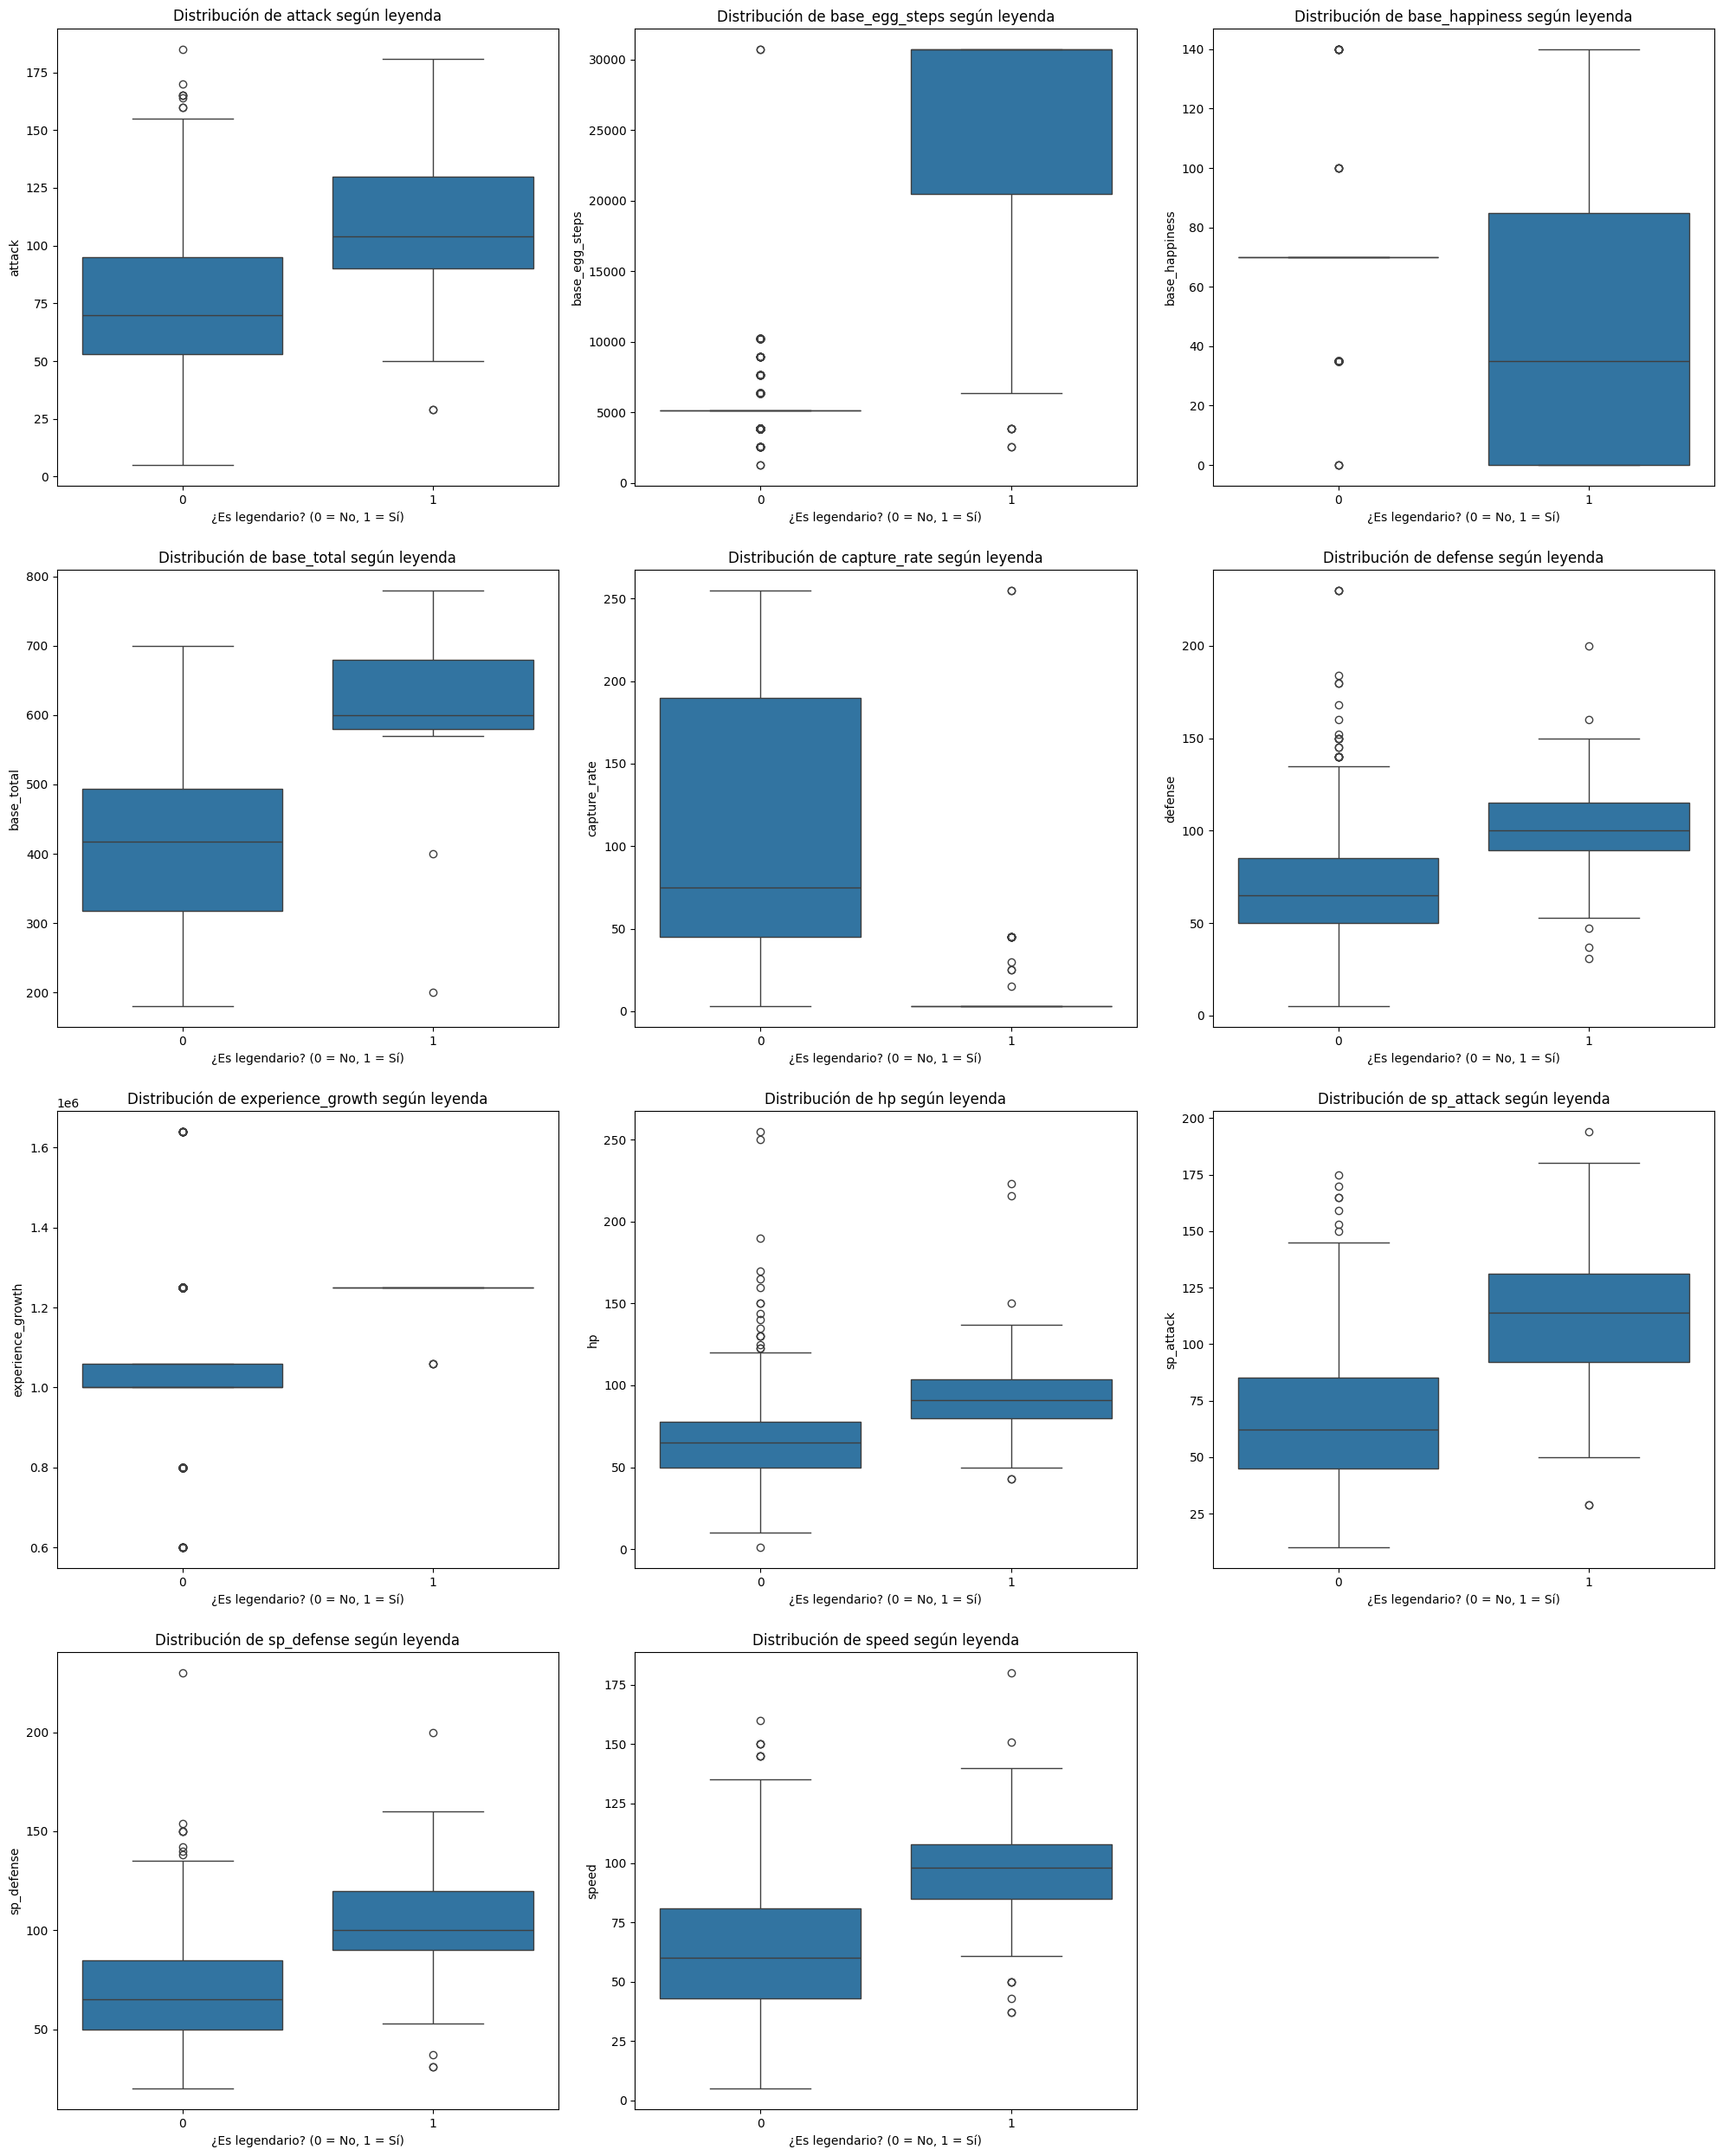

In [ ]:
features = [
    'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
    'defense', 'experience_growth', 'hp', 'sp_attack', 'sp_defense', 'speed'
]

# Asegurar tipo categórico para leyenda
data['is_legendary'] = data['is_legendary'].astype(str)

# Crear los boxplots
plt.figure(figsize=(20, 25))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='is_legendary', y=feature, data=data)
    plt.title(f'Distribución de {feature} según leyenda')
    plt.xlabel('¿Es legendario? (0 = No, 1 = Sí)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

**Rellena los valores nulos de la variable `percentage_male` con un -1, que se va a corresponder con aquellos Pokémon que no tienen género.**

In [ ]:
data.fillna({'percentage_male': -1}, inplace=True)

# Verificar que no quedan nulos
print(data['percentage_male'].isnull().sum())

0


**Imputa los valores ausentes de peso y altura con el peso y la altura medios para el `type1` de ese Pokémon. Comprueba que ya no tienes valores ausentes en esas columnas.**

In [ ]:
# Imputamos la altura
data['height_m'] = data.groupby('type1')['height_m'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Imputamos el peso
data['weight_kg'] = data.groupby('type1')['weight_kg'].transform(lambda x: x.fillna(x.mean()))


In [ ]:
# Calculamos el número de valores ausentes
data[['height_m', 'weight_kg']].isnull().sum()

,0
height_m,0
weight_kg,0


**Muestra en un gráfico cómo se distribuyen el peso y la altura de los Pokémon.**

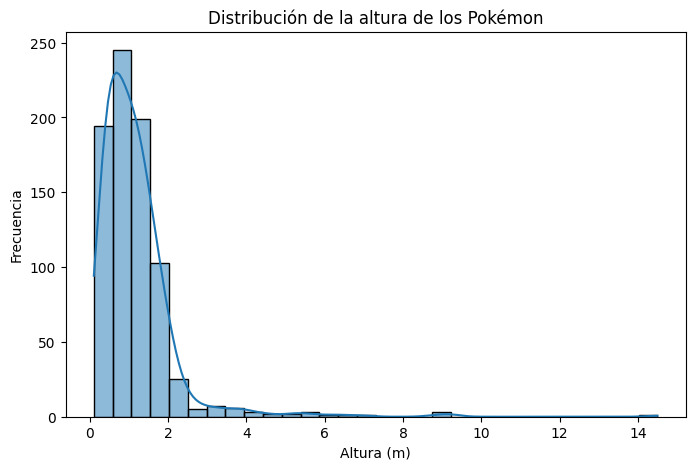

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x="height_m", bins=30, kde=True)
plt.title("Distribución de la altura de los Pokémon")
plt.xlabel("Altura (m)")
plt.ylabel("Frecuencia")
plt.show()

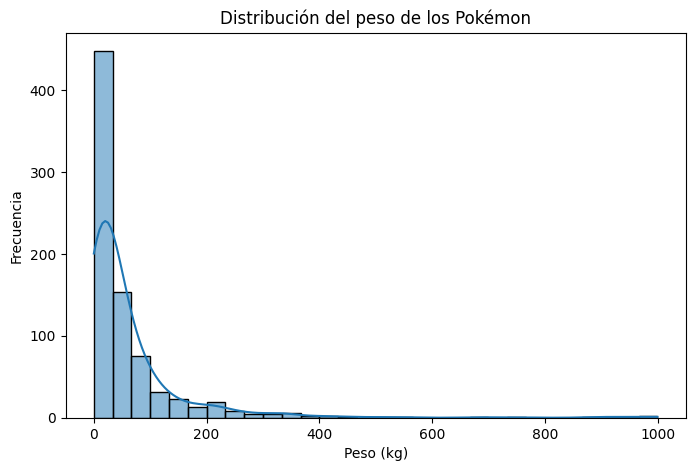

In [ ]:
# Distribución peso
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x="weight_kg", bins=30, kde=True)
plt.title("Distribución del peso de los Pokémon")
plt.xlabel("Peso (kg)")
plt.ylabel("Frecuencia")
plt.show()

**Crea un scatterplot usando la altura y peso de los Pokémon en el que se diferencie entre legendarios y no legendarios. Anota en el gráfico el nombre de los 5 Pokémon más pesados y los 5 más altos. ¿Qué deduces del gráfico?**

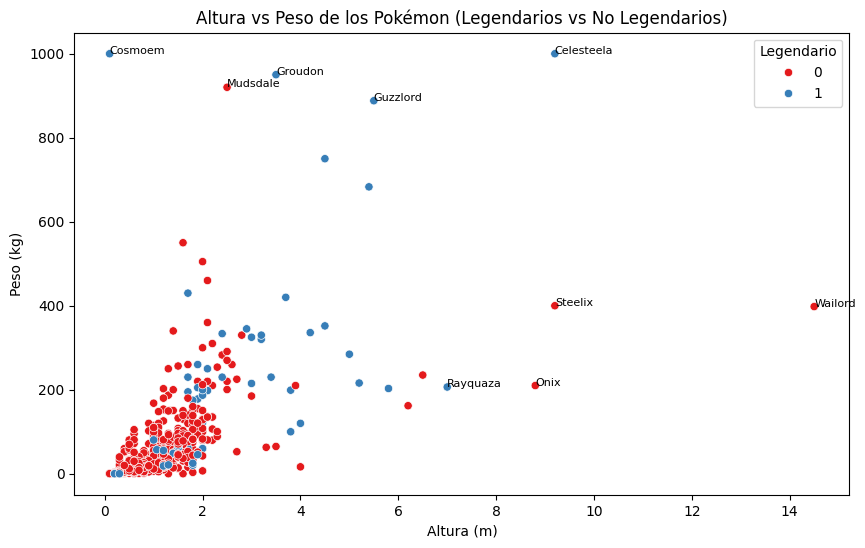

In [ ]:
# Obtener los 5 Pokémon más pesados y los 5 más altos
top_pesados = data.nlargest(5, 'weight_kg')
top_altos = data.nlargest(5, 'height_m')

# Concatenar y eliminar duplicados, pero excluyendo la columna 'abilities'
anotados = pd.concat([top_pesados, top_altos]).drop_duplicates(subset=data.columns.difference(['abilities']))
# We specify the 'subset' argument to exclude 'abilities' from the duplicate check

# Crear el scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="height_m", y="weight_kg", hue="is_legendary", palette="Set1")

# Anotar nombres
for _, row in anotados.iterrows():
    plt.text(row["height_m"], row["weight_kg"], row["name"], fontsize=8)

plt.title("Altura vs Peso de los Pokémon (Legendarios vs No Legendarios)")
plt.xlabel("Altura (m)")
plt.ylabel("Peso (kg)")
plt.legend(title="Legendario")
plt.show()

**Analiza usando un mapa de calor la correlación existente entre las variables `against_?` del conjunto de datos y la variable de salida. ¿Qué conclusiones sacas?**

In [ ]:
# Nos quedamos con las variables que queremos analizar
against_columns = [col for col in data.columns if col.startswith("against_")]
against_columns.append("is_legendary")
corr_data = data[against_columns]

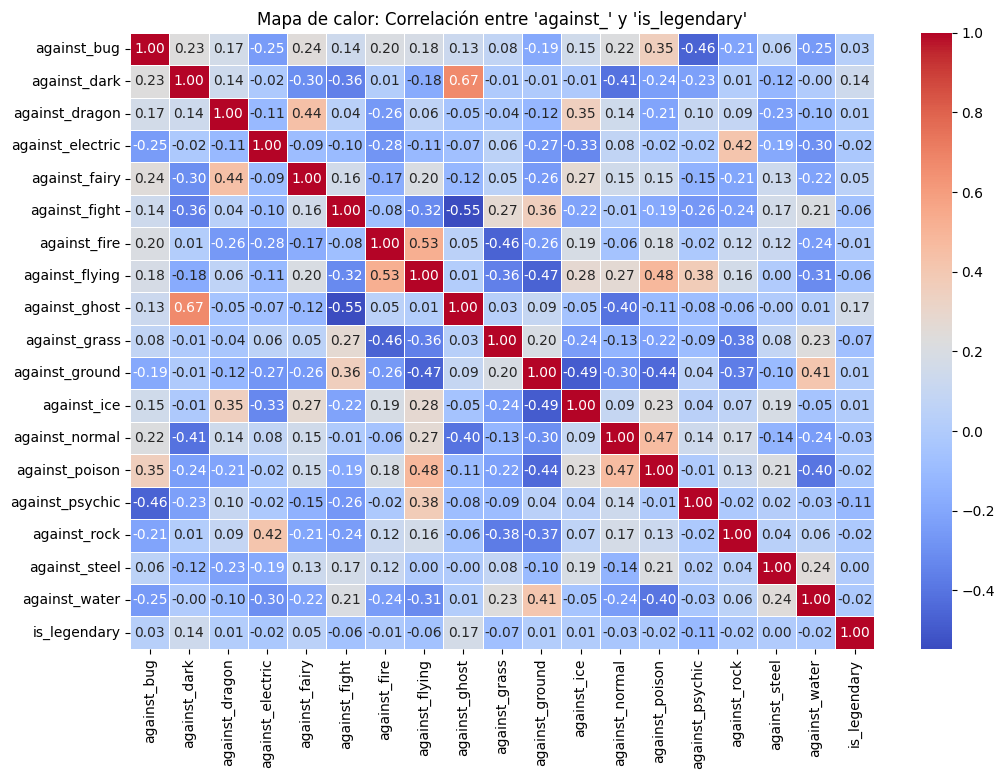

In [ ]:
# Crea el mapa de calor con los índices de correlación

plt.figure(figsize=(12, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de calor: Correlación entre 'against_' y 'is_legendary'")
plt.show()

**En base en a lo analizado hasta ahora, quédate con las columnas que consideres más informativas a efectos predictivos.**

In [ ]:
features = [
    'base_total', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed',
    'hp', 'capture_rate', 'height_m', 'weight_kg', 'generation',
    'percentage_male'
]

# Añadir variables against_
features += [col for col in data.columns if col.startswith("against_")]

# Incluir tipos (si se codifican luego)
features += ['type1', 'type2']

**Crea un mapa de calor que muestre cómo se correlacionan las características seleccionadas y la variable a predecir, ¿qué observas?**

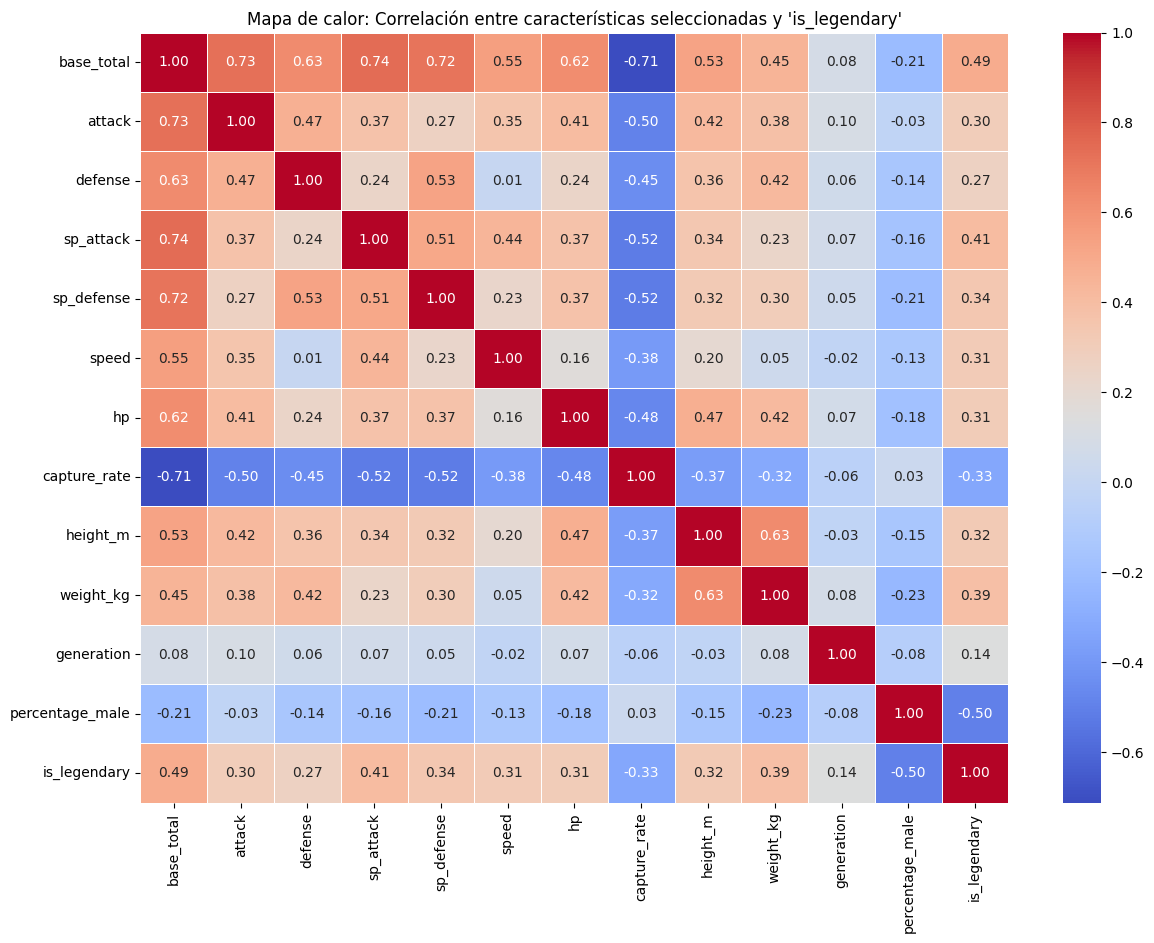

In [ ]:
# Seleccionar las columnas informativas
selected_features = [
    'base_total', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed',
    'hp', 'capture_rate', 'height_m', 'weight_kg', 'generation',
    'percentage_male'
]

# Agregar columnas against_
#selected_features += [col for col in data.columns if col.startswith("against_")]

# Incluir variable objetivo
selected_features.append('is_legendary')

# Filtrar el DataFrame
corr_matrix = data[selected_features].corr()

# Crear el mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de calor: Correlación entre características seleccionadas y 'is_legendary'")
plt.show()

## División conjuntos de entrenamiento y prueba

**Separa las variables de entrada de la variable de salida y asígnalas a dos variables llamadas `X` e `y` respectivamente.**

In [ ]:
# Agregar variables against_
features += [col for col in data.columns if col.startswith("against_")]

# Incluir tipos (codificados posteriormente)
features += ['type1', 'type2']

# Separar variables de entrada y salida
X = data[features]
y = data['is_legendary']

# Codificar variables categóricas 'type1' y 'type2'
X = pd.get_dummies(X, columns=['type1', 'type2'], drop_first=True)


**Divide el dataset en los conjuntos de entrenamiento y prueba usando la función `train_test_split()` de la librería Scikit-Learn en una proporción de 70/30. Usa un `random_state=0` y estratifica en base a `y`.**

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Verificamos tamaños de los conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((560, 118), (241, 118), (560,), (241,))

## Entrenar y evaluar clasificadores

**Entrena y evalúa un clasificador $k$-NN. Selecciona para ello el mejor valor de $k$.**

In [ ]:
# Escala los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Recrea el dataset de entrenamiento con las columnas estandarizadas
X_train = pd.DataFrame(X_train, columns=X.columns)

In [ ]:
# Escala el conjunto de prueba
X_test = scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Recrea el dataset de prueba con las columnas estandarizadas

X_test = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
# Usa GridSearchCV para seleccionar k
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]} # Valores de k a probar


In [ ]:
# Entrena el clasificador

# Crea el modelo k-NN
knn = KNeighborsClassifier()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Entrena el modelo con la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
             scoring='accuracy')

In [ ]:
# Muestra el mejor k
print("Mejor valor de k:", grid_search.best_params_['n_neighbors'])

Mejor valor de k: 5


In [ ]:
# Obtén el mejor modelo de la búsqueda en cuadrícula
best_knn = grid_search.best_estimator_
best_knn

KNeighborsClassifier()

In [ ]:
# Realiza las predicciones

# Realiza predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

In [ ]:
# Imprime la exactitud en los set de entrenamiento y prueba

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Imprime las exactitudes
print(f"Exactitud en el conjunto de entrenamiento: {train_accuracy:.4f}")
print(f"Exactitud en el conjunto de prueba: {test_accuracy:.4f}")

Exactitud en el conjunto de entrenamiento: 0.9375
Exactitud en el conjunto de prueba: 0.9129


In [ ]:
# Calcula la matriz de confusión

cm = confusion_matrix(y_test, y_test_pred)

# Imprime la matriz de confusión
print("Matriz de confusión:")
cm

Matriz de confusión:


array([[220,   0],
       [ 21,   0]])

In [ ]:
# Imprime el informe de clasificación

report = classification_report(y_test, y_test_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       220
           1       0.00      0.00      0.00        21

    accuracy                           0.91       241
   macro avg       0.46      0.50      0.48       241
weighted avg       0.83      0.91      0.87       241



### Entrena y evalúa un clasificador de **Regresión Logística**. Ajusta sus hiperparámetros.**

In [ ]:
# Usa GridSearchCV para seleccionar los hiperparámetros
# Te proponemos estos pero prueba los que quieras
param_dict = {'solver': ['lbfgs', 'liblinear'],
              'penalty': ['l2'],
              'C': [100, 10, 1.0, 0.1, 0.01]}

In [ ]:
# Entrena el clasificador

# Crea el modelo de regresión logística
logreg = LogisticRegression()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(logreg, param_grid=param_dict, cv=5, scoring='accuracy')

# Entrena el clasificador
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [ ]:
# Muestra los mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
# Obtén el mejor modelo
best_logreg = grid_search.best_estimator_
best_logreg

LogisticRegression(C=10)

In [ ]:
# Realiza las predicciones

y_train_pred = best_logreg.predict(X_train)
y_test_pred = best_logreg.predict(X_test)

In [ ]:
# Imprime la exactitud en los set de entrenamiento y prueba

print(f"Exactitud en el conjunto de entrenamiento: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Exactitud en el conjunto de prueba: {accuracy_score(y_test, y_test_pred):.4f}")

Exactitud en el conjunto de entrenamiento: 0.9821
Exactitud en el conjunto de prueba: 0.9129


In [ ]:
# Calcula la matriz de confusión

c_m = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión:")
print(c_m)


Matriz de confusión:
[[220   0]
 [ 21   0]]


In [ ]:
# Imprime el informe de clasificación
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       220
           1       0.00      0.00      0.00        21

    accuracy                           0.91       241
   macro avg       0.46      0.50      0.48       241
weighted avg       0.83      0.91      0.87       241



### Entrena y evalúa un clasificador de **Arbol de Decisión**. Ajusta sus hiperparámetros.**

In [ ]:
# Usa GridSearchCV para seleccionar los hiperparámetros
# Te proponemos estos pero prueba los que quieras
param_dict = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'class_weight': ['balanced', None]
}



In [ ]:
# Crea el modelo de árbol de decisión
tree = DecisionTreeClassifier()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(tree, param_grid=param_dict, cv=5, scoring='accuracy')

# Entrena el clasificador
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, None]},
             scoring='accuracy')

In [ ]:
# Muestra los mejores parámetros
print("Mejores Hyparámetros:", grid_search.best_params_)

Mejores parámetros: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3}


In [ ]:
# Realiza las predicciones
# Obtén el mejor modelo
best_tree = grid_search.best_estimator_

# Realiza predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

In [ ]:
# Imprime la exactitud en los conjuntos de entrenamiento y prueba
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Exactitud en el conjunto de prueba: {accuracy_score(y_test, y_test_pred):.4f}")


Exactitud en el conjunto de entrenamiento: 0.9946
Exactitud en el conjunto de prueba: 0.7842


In [ ]:
# Calcula la matriz de confusión
cm_ = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión:")
print(cm_)

Matriz de confusión:
[[185  35]
 [ 17   4]]


In [ ]:
# Imprime el informe de clasificación
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       220
           1       0.10      0.19      0.13        21

    accuracy                           0.78       241
   macro avg       0.51      0.52      0.51       241
weighted avg       0.84      0.78      0.81       241



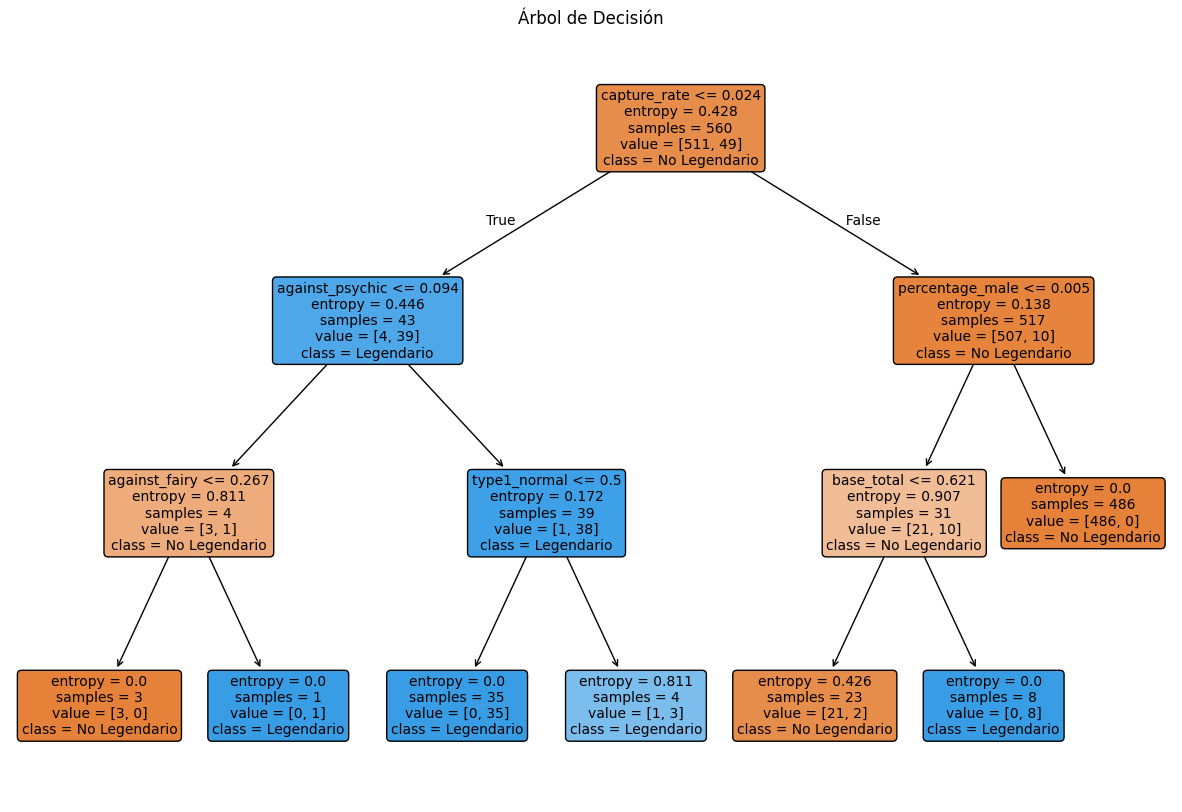

<Figure size 640x480 with 0 Axes>

In [ ]:
# Muestra el árbol de decisión
plt.figure(figsize=(15, 10))  # Ajusta el tamaño de la figura si es necesario
plot_tree(best_tree,
          feature_names=X_train.columns,
          class_names=['No Legendario', 'Legendario'],
          filled=True,
          rounded=True,
          fontsize=10)  # Ajusta el tamaño de la fuente si es necesario
plt.title("Árbol de Decisión")
plt.show()

# Guarda la imagen
plt.savefig("arbol_decision.png")


In [ ]:
# Crea un informe de texto del árbol de decisión
tree_rules = export_text(best_tree, feature_names=list(X_train.columns))

# Imprime las reglas
print(tree_rules)

|--- capture_rate <= 0.02
|   |--- against_psychic <= 0.09
|   |   |--- against_fairy <= 0.27
|   |   |   |--- class: 0
|   |   |--- against_fairy >  0.27
|   |   |   |--- class: 1
|   |--- against_psychic >  0.09
|   |   |--- type1_normal <= 0.50
|   |   |   |--- class: 1
|   |   |--- type1_normal >  0.50
|   |   |   |--- class: 1
|--- capture_rate >  0.02
|   |--- percentage_male <= 0.00
|   |   |--- base_total <= 0.62
|   |   |   |--- class: 0
|   |   |--- base_total >  0.62
|   |   |   |--- class: 1
|   |--- percentage_male >  0.00
|   |   |--- class: 0



In [ ]:
# Muestra la importancia de las características
# pero solo las que tienen importancia > 0


# Obtén la importancia de las características
feature_importances = best_tree.feature_importances_

# Crea un DataFrame con los nombres de las características y su importancia
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Filtra las características con importancia > 0
important_features = feature_importance_df[feature_importance_df['importance'] > 0]

# Ordena las características por importancia (de mayor a menor)
important_features = important_features.sort_values('importance', ascending=False)

# Imprime las características importantes
print(important_features)

            feature  importance
7      capture_rate    0.658722
11  percentage_male    0.190079
0        base_total    0.080817
44  against_psychic    0.040782
76     type1_normal    0.015284
34    against_fairy    0.014316


**Entrena y evalúa un clasificador de Maquinas de Soporte Vectorial. Ajusta sus hiperparámetros.**

In [ ]:
# Define los hiperparámetros a ajustar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

In [ ]:
# Crea el modelo SVM
svm = SVC()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=3, scoring='accuracy')

# Entrena el clasificador
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.920 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.911 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.911 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.911 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.911 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.929 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.938 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.938 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.938 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.929 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.920 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=3)

In [ ]:
# Muestra los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [ ]:
# Obtén el mejor modelo
best_svm = grid_search.best_estimator_

# Realiza predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

In [ ]:
# Imprime la exactitud en los conjuntos de entrenamiento y prueba
print(f"Exactitud en el conjunto de entrenamiento: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Exactitud en el conjunto de prueba: {accuracy_score(y_test, y_test_pred):.4f}")

Exactitud en el conjunto de entrenamiento: 0.9839
Exactitud en el conjunto de prueba: 0.9129


In [ ]:
# Calcula e imprime la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[220   0]
 [ 21   0]]


In [ ]:
# Imprime el informe de clasificación
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       220
           1       0.00      0.00      0.00        21

    accuracy                           0.91       241
   macro avg       0.46      0.50      0.48       241
weighted avg       0.83      0.91      0.87       241



## Comparar desempeño de los clasificadores

**Muestra la curva ROC para cada unos de los clasificadores en una misma gráfica e incluye en la visualización el AUC. Interpreta los resultados.**

In [ ]:
# Calcula las probabilidades de predicción de cada modelo

# k-NN
y_probs_knn = best_knn.predict_proba(X_test)[:, 1]

# Regresión Logística
y_probs_logreg = best_logreg.predict_proba(X_test)[:, 1]

# Árbol de Decisión
y_probs_tree = best_tree.predict_proba(X_test)[:, 1]

# SVM
y_probs_svm = best_svm.decision_function(X_test)

In [ ]:
from sklearn.metrics import roc_curve

# Convertimos y_test a tipo numerico antes de calcular la Curva ROC
y_test_numeric = pd.to_numeric(y_test)

# Calculamos la curva ROC con numeric y_test
fpr_knn, tpr_knn, _ = roc_curve(y_test_numeric, y_probs_knn)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_numeric, y_probs_logreg)
fpr_tree, tpr_tree, _ = roc_curve(y_test_numeric, y_probs_tree)
fpr_svm, tpr_svm, _ = roc_curve(y_test_numeric, y_probs_svm)

# Calculamos la curva ROC desde random classifier como referencia
ns_probs = [0 for _ in range(len(y_test))]
fpr_ns, tpr_ns, _ = roc_curve(y_test_numeric, ns_probs)

In [ ]:
# Calcula la puntuación AUC para los modelos
from sklearn.metrics import roc_auc_score

# Calcula la puntuación AUC para cada modelo
auc_knn = roc_auc_score(y_test, y_probs_knn)
auc_logreg = roc_auc_score(y_test, y_probs_logreg)
auc_tree = roc_auc_score(y_test, y_probs_tree)
auc_svm = roc_auc_score(y_test, y_probs_svm)

# Imprime las puntuaciones AUC
print(f"AUC k-NN: {auc_knn:.4f}")
print(f"AUC Regresión Logística: {auc_logreg:.4f}")
print(f"AUC Árbol de Decisión: {auc_tree:.4f}")
print(f"AUC SVM: {auc_svm:.4f}")

AUC k-NN: 0.5759
AUC Regresión Logística: 0.5481
AUC Árbol de Decisión: 0.5161
AUC SVM: 0.5794


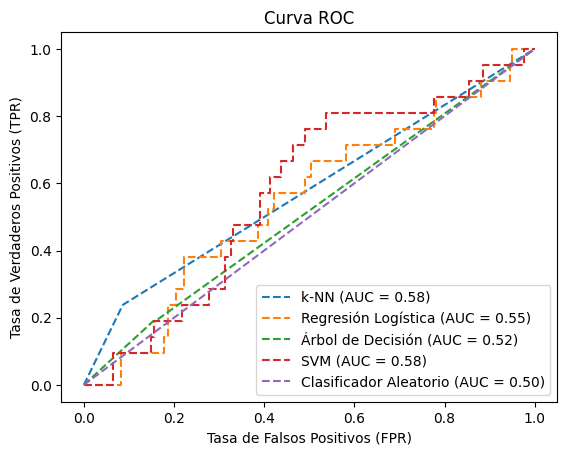

In [ ]:
# Visualiza la curva ROC para los 4 modelos
plt.plot(fpr_knn, tpr_knn, linestyle='--', label=f'k-NN (AUC = {auc_knn:.2f})')
plt.plot(fpr_logreg, tpr_logreg, linestyle='--', label=f'Regresión Logística (AUC = {auc_logreg:.2f})')
plt.plot(fpr_tree, tpr_tree, linestyle='--', label=f'Árbol de Decisión (AUC = {auc_tree:.2f})')
plt.plot(fpr_svm, tpr_svm, linestyle='--', label=f'SVM (AUC = {auc_svm:.2f})')

# Curva ROC para un clasificador aleatorio (referencia)
plt.plot(fpr_ns, tpr_ns, linestyle='--', label='Clasificador Aleatorio (AUC = 0.50)')

# Configuraciones de la gráfica
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## **¿que harías para mejorar el rendimiento de estos modelos?  Aplica los cambios que creas pertinentes**